In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import sys
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

sys.path.append("python")
from utils import print_parameters

In [74]:
checkpoint_path = "../model_weights/PDDD/ResNet50-Plant-model-80.pth"
num_classes = 120
img_size = 224
data_dir = "../datasets/PlantDoc-Dataset-windows-compatible/test/"
batch_size_valid = 1

plant_doc_classes = {
    0: "apple",
    1: "apple",
    2: "apple",
    3: "bell_pepper",
    4: "bell_pepper",
    5: "blueberry",
    6: "cherry",
    7: "corn",
    8: "corn",
    9: "corn",
    10: "grape",
    11: "grape",
    12: "peach",
    13: "potato",
    14: "potato",
    15: "raspberry",
    16: "soyabean",
    17: "squash",
    18: "strawberry",
    19: "tomato",
    20: "tomato",
    21: "tomato",
    22: "tomato",
    23: "tomato",
    24: "tomato",
    25: "tomato",
    26: "tomato",
    27: "tomato",
}

pddd_classes = {
    # NOTE: The taxonomy of the original paper is wrong. There are 122 classes listed instead of 120
    0: "apple",
    1: "apple",
    2: "apple",
    3: "apple",
    4: "apple",
    5: "apple",
    6: "apple",
    7: "apple",
    8: "orange",
    9: "tea",
    10: "tea",
    11: "tea",
    12: "tea",
    13: "tea",
    14: "tea",
    15: "tea",
    16: "tea",
    17: "raspberry",
    18: "corn",
    19: "corn",
    20: "corn",
    21: "corn",
    22: "corn",
    23: "corn",
    24: "coffee",
    25: "coffee",
    26: "coffee",
    27: "coffee",
    28: "sugarcane",
    29: "sugarcane",
    30: "tomato",
    31: "tomato",
    32: "tomato",
    33: "tomato",
    34: "tomato",
    35: "tomato",
    36: "tomato",
    37: "tomato",
    38: "tomato",
    39: "tomato",
    40: "pongamia",
    41: "pongamia",
    42: "strawberry",
    43: "strawberry",
    44: "strawberry",
    45: "strawberry",
    46: "hops",
    47: "hops",
    48: "hops",
    49: "bean",
    50: "bean",
    51: "bean",
    52: "blueberry",
    53: "rice",
    54: "rice",
    55: "rice",
    56: "rice",
    57: "rice",
    58: "cauliflower",
    59: "cauliflower",
    60: "cauliflower",
    61: "cauliflower",
    62: "wheat",
    63: "wheat",
    64: "wheat",
    65: "wheat",
    66: "wheat",
    67: "wheat",
    68: "citrus",
    69: "citrus",
    70: "citrus",
    71: "citrus",
    72: "jamun",
    73: "jamun",
    74: "pepper",
    75: "pepper",
    76: "basil",
    77: "squash",
    78: "mango",
    79: "mango",
    80: "cherry",
    81: "cherry",
    82: "cherry",
    83: "cotton",
    84: "cotton",
    85: "soyabean",
    86: "banana",
    87: "banana",
    88: "banana",
    89: "banana",
    90: "chinar",
    91: "chinar",
    92: "arjun",
    93: "arjun",
    94: "cucumber",
    95: "cucumber",
    96: "grape",
    97: "grape",
    98: "grape",
    99: "grape",
    100: "sunflower",
    101: "sunflower",
    102: "sunflower",
    103: "sunflower",
    104: "potato",
    105: "potato",
    106: "potato",
    107: "jatropha",
    108: "jatropha",
    109: "alstonia",
    110: "alstonia",
    111: "pomegranate",
    112: "pomegranate",
    113: "peach",
    114: "peach",
    115: "lemon",
    116: "lemon",
    117: "okra",
    118: "okra",
    119: "bael",
    120: "gauvra",
    121: "gauvra",
}

In [56]:
assert torch.cuda.is_available()
n_devices = torch.cuda.device_count()
for i in range(0, n_devices):
    print(torch.cuda.get_device_name(i))

device = torch.device("cuda")

NVIDIA GeForce GTX 960


In [58]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
print_parameters(model)

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

model = model.to(device)
model.eval()
print("ok")

23753912 parameters
0 required parameters
ok


In [50]:
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ]
)
ds_valid = datasets.ImageFolder(data_dir, transform=transform)

In [51]:
dl_valid = data.DataLoader(
    dataset=ds_valid,
    batch_size=batch_size_valid,
    num_workers=0,  # shuffle=True
)

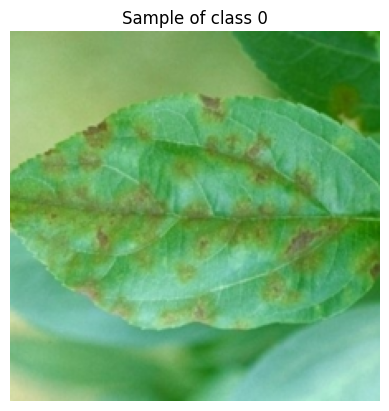

In [69]:
images, labels = next(iter(dl_valid))
images = images.to(device)


img = images[0].cpu().numpy().transpose((1, 2, 0))

plt.axis("off")

plt.title(f"Sample of class {labels[0]}")

plt.imshow(img)

In [70]:
outputs = model(images)

In [71]:
probs = softmax(outputs[0].cpu().detach().numpy())
max_idx = np.argmax(probs)
print(f"category {max_idx} with probability {probs[max_idx]} ")

category 8 with probability 0.40258386731147766 


In [81]:
false_prediction = 0
true_prediction = 0

for images, labels in dl_valid:
    images = images.to(device)
    outputs = model(images)

    for label, output in zip(labels, outputs):
        probs = softmax(output.cpu().detach().numpy())
        max_idx = np.argmax(probs)
        if plant_doc_classes[label.item()] == pddd_classes[max_idx]:
            true_prediction += 1
            # print(f"label={plant_doc_classes[label.item()]} prediction={pddd_classes[max_idx]}")
        else:
            false_prediction += 1

print(f"true_prediction: {true_prediction}")
print(f"false_prediction: {false_prediction}")
print(f"Accuracy: {true_prediction / (false_prediction+true_prediction)}")

true_prediction: 9
false_prediction: 227
Accuracy: 0.038135593220338986
